## Packages and Assets

In [43]:
from gensim.models import Word2Vec
import json
import numpy as np
import pandas as pd
from keras.callbacks import EarlyStopping
import seaborn as sns
import keras_tuner as kt
from keras.optimizers import SGD

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
import matplotlib.pyplot as plt
from keras.metrics import Accuracy, Precision, Recall
from keras.preprocessing.text import tokenizer_from_json
import os, sys


import keras.backend as K

In [2]:
print(sys.executable)
print(os.getcwd())

C:\Users\Guilherme\.conda\envs\nlp2\python.exe
C:\Users\Guilherme\Documents\Programming\Python\DataScience\TCC\pipeline\supervised_deep_models


## Dependencies

In [3]:
with open('../../assets/deep_assets/tokenizer.json', 'r', encoding='utf-8') as f:
    tokenizer_json = f.read()
    tokenizer = tokenizer_from_json(tokenizer_json)
    word_index = tokenizer.word_index



In [4]:
model_we = Word2Vec.load('../../assets/deep_assets/word2vec.model')

print(model_we.wv.most_similar('itau'))

# List of nparrays of size 300
embeddings_dict = {}
for word in model_we.wv.index_to_key:
    embeddings_dict[word] = model_we.wv[word]

embeddings_on_this_context = np.zeros((len(word_index), 300))
for word, i in word_index.items():
    embeddings_vector = embeddings_dict.get(word)
    if embeddings_vector is not None:
        embeddings_on_this_context[i - 1] = embeddings_vector


[('itub4', 0.990408718585968), ('banco', 0.9718618392944336), ('bradesco', 0.9700526595115662), ('bbas3', 0.9663271307945251), ('bbdc4', 0.9616492986679077), ('santander', 0.9615459442138672), ('xpbr31', 0.9500864148139954), ('unibanco', 0.9492729902267456), ('pagar', 0.9354850649833679), ('valioso', 0.9320330619812012)]


In [20]:
train = pd.read_csv('../../assets/data/splits/train/padded.csv')
val = pd.read_csv('../../assets/data/splits/val/padded.csv')

## Functions

In [6]:
def index2word(word_index):
    index_word = {}
    for key in word_index:
        index_word[word_index[key]] = key
    return index_word


def seq2text(seq, index_word):
    text = []
    for index in seq:
        text.append(index_word[index])
    return text


def show_confusion_matrix(cm):
    print("Confusion Matrix")
    plt.figure(figsize=(10, 7))

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.title('Confusion Matrix')
    plt.show()

In [35]:
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

## RNN Model

### Data transformation for model

In [21]:
X_train = train.to_numpy()[:, :-1]
X_val = val.to_numpy()[:, :-1]
y_train = train.to_numpy()[:, -1]
y_val = val.to_numpy()[:, -1]

### Tuning Architecture Hyperparams using RandomSearch and Early Stopping

#### Test 1

In [9]:
# def build_model(hp):
#     model = Sequential([
#         Embedding(input_dim=len(word_index), output_dim=300, input_length=X_train.shape[1], trainable=False,
#                   weights=[embeddings_on_this_context]),
#         Bidirectional(LSTM(16, return_sequences=True)),
#         Dropout(hp.Float('rate_dp_1', 0, 0.4, step=0.1)),
#         Bidirectional(LSTM(16)),
#         Dense(64, 'tanh'),
#         Dropout(hp.Float('rate_dp_1', 0.1, 0.4, step=0.1)),
#         Dense(4, activation='softmax')
#     ])
#     loss = "sparse_categorical_crossentropy"
#     # optimizer = SGD(learning_rate=0.01)
#     metrics = ['accuracy']
#
#     model.compile(loss=loss, optimizer='adam', metrics=metrics)
#     return model
#
#
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

TypeError: f1_score() missing 2 required positional arguments: 'y_true' and 'y_pred'

####  Test 2

In [58]:
def build_model(hp):
    model = Sequential([
    Embedding(input_dim=len(word_index), output_dim= 300, input_length=X_train.shape[1], trainable=False, weights=[embeddings_on_this_context]),
    Bidirectional(LSTM(hp.Choice('units_bilstm_1',[16,32,64]), return_sequences=True)),
    Dropout(hp.Float('rate_dp_1',0,0.3,step=0.1)),
    Bidirectional(LSTM(hp.Choice('units_bilstm_2',[16,32,64]))),
    Dense(hp.Choice('units_dense',[16,32,64]), hp.Choice('activation',['tanh']) ),
    Dropout(hp.Float('rate_dp_2',0,0.3,step=0.1)),
    Dense(4, activation='softmax')
])
    loss = "sparse_categorical_crossentropy"
    # optimizer = SGD(learning_rate=0.01)
    metrics = ['accuracy']
    # metrics = ['accuracy', Precision(), Recall()]

    model.compile(loss=loss,optimizer='adam',metrics=metrics)
    return model

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [59]:
# amanha testar dropout 0.0, 0.1, 0.2
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='../../assets/deep_assets',
    overwrite=True,
    project_name='lstm_tuning')

tuner.search_space_summary()

Search space summary
Default search space size: 6
units_bilstm_1 (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
rate_dp_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.1, 'sampling': 'linear'}
units_bilstm_2 (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
units_dense (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
activation (Choice)
{'default': 'tanh', 'conditions': [], 'values': ['tanh'], 'ordered': False}
rate_dp_2 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.1, 'sampling': 'linear'}


In [ ]:
tuner.search(X_train, y_train, epochs=4000, validation_data=(X_val,y_val), callbacks=[es], batch_size=32, verbose=2)

Trial 10 Complete [00h 01m 41s]
val_accuracy: 0.8339810967445374

Best val_accuracy So Far: 0.8461965322494507
Total elapsed time: 00h 23m 36s
INFO:tensorflow:Oracle triggered exit


In [62]:
tuner.results_summary()
 # 0.845774233341217

Results summary
Results in ../../assets/deep_assets\lstm_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 08 summary
Hyperparameters:
units_bilstm_1: 64
rate_dp_1: 0.1
units_bilstm_2: 32
units_dense: 32
activation: tanh
rate_dp_2: 0.0
Score: 0.8461965322494507

Trial 05 summary
Hyperparameters:
units_bilstm_1: 16
rate_dp_1: 0.0
units_bilstm_2: 16
units_dense: 64
activation: tanh
rate_dp_2: 0.1
Score: 0.8400888442993164

Trial 06 summary
Hyperparameters:
units_bilstm_1: 64
rate_dp_1: 0.2
units_bilstm_2: 16
units_dense: 32
activation: tanh
rate_dp_2: 0.0
Score: 0.8389783501625061

Trial 04 summary
Hyperparameters:
units_bilstm_1: 64
rate_dp_1: 0.0
units_bilstm_2: 64
units_dense: 32
activation: tanh
rate_dp_2: 0.1
Score: 0.8378678560256958

Trial 00 summary
Hyperparameters:
units_bilstm_1: 32
rate_dp_1: 0.0
units_bilstm_2: 64
units_dense: 64
activation: tanh
rate_dp_2: 0.2
Score: 0.8373125791549683

Trial 01 summary
Hyperparameters:
units_bilstm_1: 32
r

In [ ]:
type(tuner.results_summary())

In [63]:
with open('../../assets/deep_assets/tuner_results_10_attempts.txt', 'w') as f:
    f.write(str(tuner.results_summary()))


Results summary
Results in ../../assets/deep_assets\lstm_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 08 summary
Hyperparameters:
units_bilstm_1: 64
rate_dp_1: 0.1
units_bilstm_2: 32
units_dense: 32
activation: tanh
rate_dp_2: 0.0
Score: 0.8461965322494507

Trial 05 summary
Hyperparameters:
units_bilstm_1: 16
rate_dp_1: 0.0
units_bilstm_2: 16
units_dense: 64
activation: tanh
rate_dp_2: 0.1
Score: 0.8400888442993164

Trial 06 summary
Hyperparameters:
units_bilstm_1: 64
rate_dp_1: 0.2
units_bilstm_2: 16
units_dense: 32
activation: tanh
rate_dp_2: 0.0
Score: 0.8389783501625061

Trial 04 summary
Hyperparameters:
units_bilstm_1: 64
rate_dp_1: 0.0
units_bilstm_2: 64
units_dense: 32
activation: tanh
rate_dp_2: 0.1
Score: 0.8378678560256958

Trial 00 summary
Hyperparameters:
units_bilstm_1: 32
rate_dp_1: 0.0
units_bilstm_2: 64
units_dense: 64
activation: tanh
rate_dp_2: 0.2
Score: 0.8373125791549683

Trial 01 summary
Hyperparameters:
units_bilstm_1: 32
r

In [71]:
best_model_hp = tuner.get_best_hyperparameters()[0].values


#### Evaluation

### Tuning fit hyperparamters using GridSearch

In [ ]:
# model = Sequential([
#     Embedding(input_dim=len(word_index), output_dim= 300, input_length=X_train.shape[1], trainable=False, weights=[embeddings_on_this_context]),
#     Bidirectional(LSTM(64, return_sequences=True)),
#     # Dropout(0.29),
#     # Bidirectional(LSTM(hp.Choice('units',[32,64]))),
#     Bidirectional(LSTM(64)),
#     Dense(32, activation='relu'),
#     # Dropout(0.73),
#     Dense(4, activation='softmax')
# ])
#
# model.summary()
#
# from keras.optimizers import SGD
#
# loss = "sparse_categorical_crossentropy"
# optimizer = 'adam'
# metrics = ['accuracy']
#
# model.compile(loss=loss,optimizer=optimizer,metrics=metrics)
#
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
#
#
# history = model.fit(X_train, y_train, epochs=4000, validation_data=(X_val,y_val), verbose=2, callbacks=[es])


In [ ]:
# def architecture_tuned_model():
#     model = Sequential([
#         Embedding(input_dim=len(word_index), output_dim=300, input_length=X_train.shape[1], trainable=False,
#                   weights=[embeddings_on_this_context]),
#         Bidirectional(LSTM(32, return_sequences=True)),
#         Dropout(0.29),
#         Bidirectional(LSTM(16)),
#         Dense(64, 'tanh'),
#         Dropout(0.73),
#         Dense(4, activation='softmax')
#     ])
#     loss = "sparse_categorical_crossentropy"
#     optimizer = 'adam'
#     metrics = ['accuracy']
#
#     model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
#     return model


In [ ]:
# from keras.wrappers.scikit_learn import KerasClassifier
#
# model = KerasClassifier(build_fn=architecture_tuned_model, verbose=0)

In [ ]:
# from sklearn.model_selection import GridSearchCV
#
# es = EarlyStopping(monitor='accuracy', mode='min', verbose=1, patience=5)
#
# param_grid = {'batch_size': [1,2,4,8]}
#
# gs = GridSearchCV(estimator=model,
#                   param_grid=param_grid,
#                   cv=5)
# gs.fit(X_train, y_train, callbacks=[es])
# print(f"Best results for {model.__class__.__name__}")
# print("Best Score of train set: " + str(gs.best_score_))
# print("Best estimator: " + str(gs.best_estimator_))
# print("Best parameter set: " + str(gs.best_params_))


In [ ]:
# gs.best_estimator_.model.history.history
# # 0.7766810655593872

In [ ]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
# ax1.plot(gs.best_estimator_.model.history.history['accuracy'])
# ax1.plot(gs.best_estimator_.model.history.history['loss'])
# ax1.set_title('Model Accuracy')
# ax1.set_ylabel('Accuracy')
# ax1.set_xlabel('Epoch')
# ax1.legend(['Train', 'Validation'], loc='upper left')
#
# ax2.plot(gs.best_estimator_.model.history.history['loss'])
# ax2.plot(gs.best_estimator_.model.history.history['val_loss'])
# ax2.set_title('Model Loss')
# ax2.set_ylabel('Loss')
# ax2.set_xlabel('Epoch')
# ax2.legend(['Train', 'Validation'], loc='upper left')
# plt.show()

{'units_bilstm_1': 64,
 'rate_dp_1': 0.1,
 'units_bilstm_2': 32,
 'units_dense': 32,
 'activation': 'tanh',
 'rate_dp_2': 0.0}

### Tuning fit hyperparameters manually

In [72]:
best_model = Sequential([
    Embedding(input_dim=len(word_index), output_dim= 300, input_length=X_train.shape[1], trainable=False, weights=[embeddings_on_this_context]),
    Bidirectional(LSTM(best_model_hp['units_bilstm_1'], return_sequences=True)),
    Dropout(best_model_hp['rate_dp_1']),
    # Bidirectional(LSTM(hp.Choice('units',[32,64]))),
    Bidirectional(LSTM(best_model_hp['units_bilstm_2'])),
    Dense(best_model_hp['units_dense'], activation=best_model_hp['activation']),
    # Dropout(0.73),
    Dense(4, activation='softmax')
])





loss = "sparse_categorical_crossentropy"
optimizer = 'adam'
metrics = ['accuracy']


best_model.compile(loss=loss,optimizer=optimizer,metrics=metrics)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)


best_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 11, 300)           3120900   
                                                                 
 bidirectional_2 (Bidirectio  (None, 11, 128)          186880    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 11, 128)           0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 4)                

In [73]:
history = best_model.fit(X_train, y_train, epochs=4000, batch_size=32, validation_data=(X_val,y_val), verbose=2, callbacks=[es])

Epoch 1/4000
451/451 - 18s - loss: 0.8896 - accuracy: 0.6495 - val_loss: 0.7289 - val_accuracy: 0.7285 - 18s/epoch - 41ms/step
Epoch 2/4000
451/451 - 8s - loss: 0.6888 - accuracy: 0.7419 - val_loss: 0.5999 - val_accuracy: 0.7885 - 8s/epoch - 18ms/step
Epoch 3/4000
451/451 - 8s - loss: 0.5943 - accuracy: 0.7835 - val_loss: 0.5686 - val_accuracy: 0.7940 - 8s/epoch - 18ms/step
Epoch 4/4000
451/451 - 9s - loss: 0.5477 - accuracy: 0.8018 - val_loss: 0.5374 - val_accuracy: 0.8090 - 9s/epoch - 19ms/step
Epoch 5/4000
451/451 - 9s - loss: 0.5192 - accuracy: 0.8130 - val_loss: 0.5168 - val_accuracy: 0.8179 - 9s/epoch - 20ms/step
Epoch 6/4000
451/451 - 10s - loss: 0.4968 - accuracy: 0.8199 - val_loss: 0.5113 - val_accuracy: 0.8218 - 10s/epoch - 23ms/step
Epoch 7/4000
451/451 - 7s - loss: 0.4769 - accuracy: 0.8274 - val_loss: 0.4980 - val_accuracy: 0.8306 - 7s/epoch - 16ms/step
Epoch 8/4000
451/451 - 8s - loss: 0.4672 - accuracy: 0.8330 - val_loss: 0.4993 - val_accuracy: 0.8234 - 8s/epoch - 18ms/s

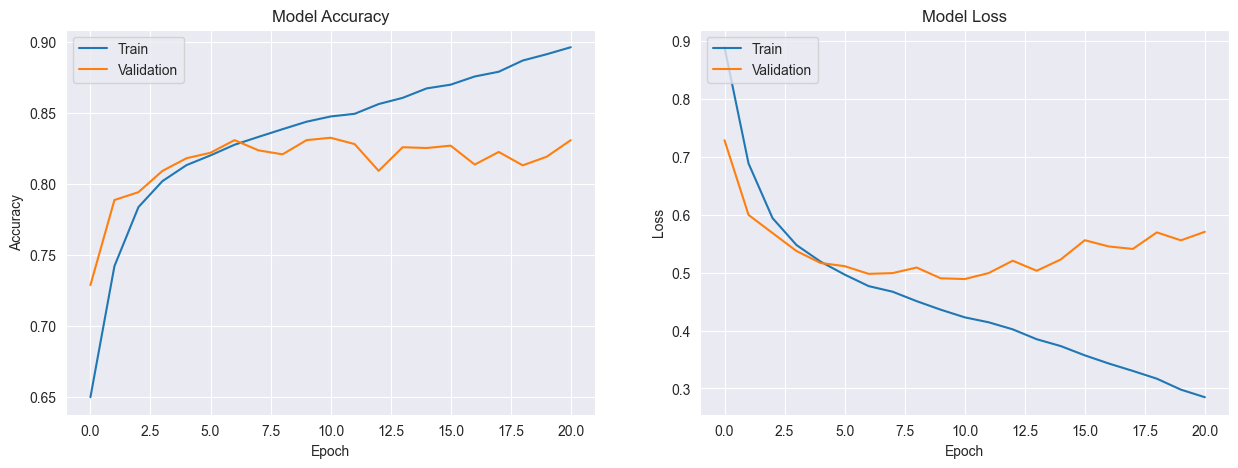

In [74]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Exporting model

In [75]:
best_model.save('../../assets/deep_assets/lstm_model')

INFO:tensorflow:Assets written to: ../../assets/deep_assets/lstm_model\assets


INFO:tensorflow:Assets written to: ../../assets/deep_assets/lstm_model\assets
